In [17]:
import pywt
import h5py
import matplotlib.cm as cm
from matplotlib import pyplot as plt
import numpy as np
import hassCS
import sewar

### Getting local filepath and importing the data

In [3]:
import socket
socket.gethostname()

'Paisam'

In [4]:
with open(r'data\data_filepath.txt', 'r') as file:
    pc_name, filepath = file.read().replace('\n', '').split(',')
    
    if socket.gethostname() == pc_name:
        data_filepath = filepath
    else:
        data_filepath = 'data.h5'

data_filepath

'data.h5'

(256, 256, 256)

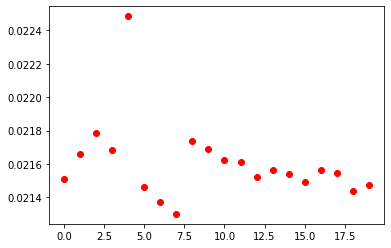

In [6]:
filename = data_filepath 
original = h5py.File(filename,'r')
fid = h5py.File(filename,'r')

arr = np.zeros([256,256,256])
for ix,k in enumerate(fid):
    data = fid[k][()]
    if ix==20:
        break
    arr= data + arr
    # Average signal in each file
    plt.plot(ix,data.mean(),'or')
arr = np.array(arr)
arr.shape

### Here we plot the effects on sparsity when summing over the spectral axis

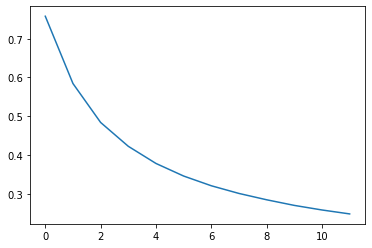

In [12]:
#Sanity check
ordered_sparsity_spectral = []
intensity = []
start_index = 8
for i in range(start_index,20):
    original = arr[:,:,start_index-1:i]
    original = original.sum(2)
    gini = hassCS.gini(original)
#     print(i,original.sum(),gini)
    ordered_sparsity_spectral.append(gini)
    intensity.append(original.sum())
#plt.plot(intensity)
plt.plot(ordered_sparsity_spectral)

# For Compressed Sensing

### Here we run a summation on the spectral axis, increasing the number of frames summed to decrease the levels of sparsity

In [80]:
def spectral_cs(arr, wavelet):
    original = []
    sparsity_spectral = []
    img_corr_spectral = []
    for i in range(8,50):
        original = arr[:,:,7:i]
        original = original.sum(2)
        X_reconstructed, Xw = hassCS.single_rec(original,wavelet = wavelet)
        sparsity_spectral.append(hassCS.gini(original))
        img_corr_spectral.append(sewar.scc(original,X_reconstructed))
    return sparsity_spectral, img_corr_spectral

bior_sparse, bior_corr = spectral_cs(arr,"bior1.3")
haar_sparse, haar_corr = spectral_cs(arr, "haar")
rbio_sparse, rbio_corr = spectral_cs(arr, "rbio1.3")

### After running compressed sensing we plot the performance of the algorithm against the decreasing levels of sparsity in the data to find the breaking point

In [81]:
def spectral_plot(sparsity_spectral,img_corr_spectral,wavelet):
    #The lighter the color the larger the slice of spectral used
    cmap = cm.inferno  
    norm = plt.Normalize(0, len(sparsity_spectral))
    fig, axes = plt.subplots()
    colors = cmap(norm(range(len(sparsity_spectral))))
    plt.scatter(sparsity_spectral, img_corr_spectral, c = colors, marker='o', edgecolors='k',s=100, alpha=0.7)

    plt.title(f'Sparsity vs. Image Correlation for Spectral Axis {wavelet}', fontsize=16, fontweight='bold')
    plt.xlabel('Sparsity', fontsize=14)
    plt.ylabel('Image Correlation', fontsize=14)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    return plt.plot(sparsity_spectral, img_corr_spectral, color='gray', linewidth=1, alpha=0.7)

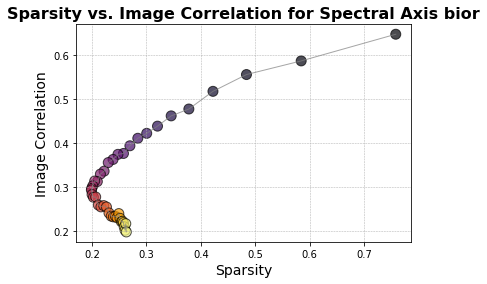

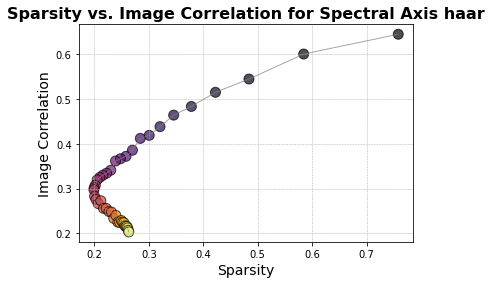

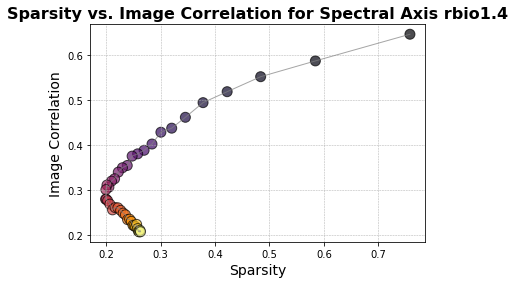

In [82]:
# The color indicates the order of the data (dark->light)
spectral_plot(bior_sparse,bior_corr,"bior")
spectral_plot(haar_sparse,haar_corr, "haar")
spectral_plot(rbio_sparse, rbio_corr, "rbio1.4")

### Note: Time axis summation omitted due to no measurable change in sparsity

# For Compression

In [54]:
def wavelet_compr(data,wavelet = "bior1.3",threshold = 20):
    # Applying wavelet transform and storing coefficients
    coeffs = pywt.dwt2(data, wavelet)
    cA, (cH, cV, cD) = coeffs
    
    # Thresholding values to keep only low values
    cA_thresholded = pywt.threshold(cA, threshold, mode='soft')
    cH_thresholded = pywt.threshold(cH, threshold, mode='soft')
    
    #Compress the image
    coeffs_thresholded = (cA_thresholded, (cH_thresholded, cV, cD))
    img_compressed = pywt.idwt2(coeffs_thresholded, 'bior1.3')
    
    return img_compressed

In [55]:
def spectral_c(arr, wavelet):
    original = []
    sparsity_spectral = []
    img_corr_spectral = []
    for i in range(8,50):
        original = arr[:,:,7:i]
        original = original.sum(2)
        X_reconstructed = wavelet_compr(original)
        sparsity_spectral.append(hassCS.gini(original))
        img_corr_spectral.append(sewar.scc(original,X_reconstructed))
    return sparsity_spectral, img_corr_spectral

In [58]:
bior_sparse_c, bior_corr_c = spectral_c(arr,"bior1.3")
haar_sparse_c, haar_corr_c = spectral_c(arr, "haar")
rbio_sparse_c, rbio_corr_c = spectral_c(arr, "rbio1.3")

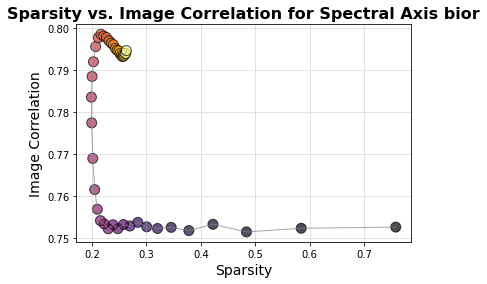

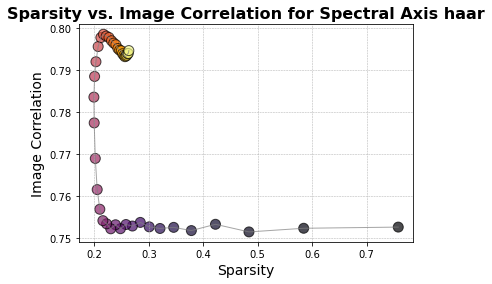

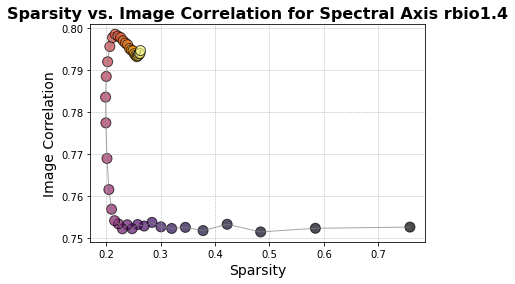

In [79]:
# The color indicates the order of the data (dark->light)
spectral_plot(bior_sparse_c,bior_corr_c,"bior")
spectral_plot(haar_sparse_c,haar_corr_c, "haar")
spectral_plot(rbio_sparse_c, rbio_corr_c, "rbio1.4")

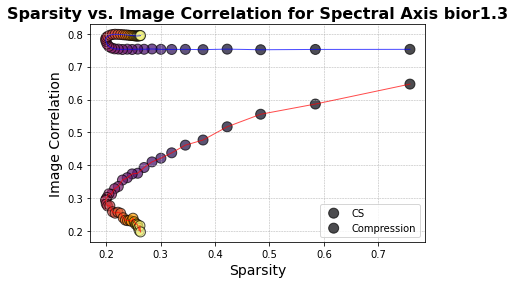

In [84]:
wavelet = "bior1.3"
fig, ax = plt.subplots()

# Create a color map based on the first dataset
cmap = cm.inferno  
norm_c = plt.Normalize(0, len(bior_sparse_c))
colors_c = cmap(norm_c(range(len(bior_sparse_c))))

# Scatter and plot for the first set
plt.scatter(bior_sparse_c, bior_corr_c, c=colors_c, marker='o', edgecolors='k', s=100, alpha=0.7, label="CS")
ax.plot(bior_sparse_c, bior_corr_c, color='blue', linewidth=1, alpha=0.7)

# Create a different color map for the second dataset (or use the same if appropriate)
norm = plt.Normalize(0, len(bior_sparse))
colors = cmap(norm(range(len(bior_sparse))))

# Scatter and plot for the second set
plt.scatter(bior_sparse, bior_corr, c=colors, marker='o', edgecolors='k', s=100, alpha=0.7, label="Compression")
ax.plot(bior_sparse, bior_corr, color='red', linewidth=1, alpha=0.7)

# Title and labels
plt.title(f'Sparsity vs. Image Correlation for Spectral Axis {wavelet}', fontsize=16, fontweight='bold')
plt.xlabel('Sparsity', fontsize=14)
plt.ylabel('Image Correlation', fontsize=14)

# Grid and legend
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

Looks like at around .2 gini level or sparsity level, there is a breaking point in the data